In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn
import glob
import librosa
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import seaborn as sn
import matplotlib.pyplot as plt
## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
!pip install keras.utils
import keras.utils
!pip install tensorflow
import tensorflow
#from keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#labels = ["angry", "disgusted", "fearful", "happy", "neutral", "sad"]
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}


observed_emotions = ['sad','angry','happy','disgust','neutral','fear']

In [ ]:
#not used
def extract_feature(file_name):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    mfccs = librosa.feature.melspectrogram(y=X, sr=sample_rate)
    return mfccs

In [ ]:
#not used for training
def load_data(test_size=0.2): 
    x,y=[],[]
    
    # feature to extract
    mfcc = True

    for file in os.listdir("/content/drive/MyDrive/ryerson"):
        path = "/content/drive/MyDrive/ryerson/"
        file_name = path+file
        for audio in os.listdir(file_name):
            audio_file = file_name + "/" + audio
            emotion=emotions[audio_file.split("-")[2]] #to get emotion according to filename. dictionary emotions is defined above.
            if emotion not in observed_emotions: #options observed_emotions - RAVDESS and TESS, ravdess_emotions for RAVDESS only
                continue
            feature=extract_feature(audio_file, mfcc)
            x.append(feature)
            y.append(emotion)
        

    for file in os.listdir("/content/drive/MyDrive/toronto/TESS Toronto emotional speech set data"):
        path = "/content/drive/MyDrive/toronto/TESS Toronto emotional speech set data/"
        file_name = path+file
        for audio in os.listdir(file_name):
            audio_file = file_name + "/" + audio
            emotion=audio.split("_")[2][:-4] #split and remove .wav
            if emotion not in observed_emotions: #options observed_emotions - RAVDESS and TESS, ravdess_emotions for RAVDESS only
                continue
            feature=extract_feature(audio_file, mfcc)
            x.append(feature[0])
            y.append(emotion)

    return {"X":x,"y":y}

In [ ]:
#not used for training

#Trial_dict = load_data(test_size = 0.3)

In [ ]:
#not used for training

#X = pd.DataFrame(Trial_dict["X"])
#y = pd.DataFrame(Trial_dict["y"])

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/CS464 Project/RAVTESS_MFCC_Observed.csv")
data = data.drop('Unnamed: 0',axis=1)
X = data.drop('emotion', axis = 1).values
y = data['emotion'].values

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,emotion
0,-512.883911,57.364391,17.080887,22.461151,3.165413,17.127214,-19.047163,-8.554851,-18.021544,14.430445,-13.958061,11.447804,-6.984544,10.246264,-0.406156,-1.396502,1.733015,5.940756,5.089407,-3.323593,5.926631,1.124013,-4.221565,0.658900,-5.681535,0.940563,1.861816,4.236084,2.952379,5.638145,4.377983,5.327526,2.002077,4.345651,9.767968,10.746924,13.613222,14.245697,10.242604,8.848364,sad
1,-423.976929,72.107246,-8.895686,26.045773,-21.497879,7.961668,-8.941034,-2.356802,-12.499807,7.922379,-13.600839,8.333814,-10.043387,5.377828,-5.195395,-1.930755,-1.817102,-0.096166,-7.649230,0.021990,-6.319166,-1.288345,-3.448888,3.912460,-1.243477,0.390959,-0.573938,1.397245,1.396395,4.588929,-0.053272,2.795042,2.061146,1.395552,5.306121,2.917225,6.070544,3.351685,3.721366,2.546432,disgust
2,-479.606476,60.020325,-22.544024,21.445721,0.215445,-4.377944,-6.196318,0.808999,-16.222569,5.685111,-5.890694,1.174196,-1.360554,0.574834,-0.721523,3.440356,-5.116458,-0.102093,-3.947001,-0.314869,-4.875519,0.778866,-1.585237,-1.849678,-1.847233,1.092521,-3.564824,-0.000438,-4.550419,2.057372,2.670676,2.381834,5.468719,1.215846,1.305446,2.757224,4.803069,8.149659,13.111974,10.990307,fear
3,-377.455566,73.082817,-10.737463,-7.462482,-23.641148,-4.974933,-23.276512,8.385411,-23.189186,-0.063893,-9.823548,6.005100,-5.702047,8.406502,-1.954097,-0.765503,2.988822,-7.720791,-3.357804,-14.964339,-7.857167,4.007063,2.325056,24.812960,32.682426,29.723614,24.545841,11.989907,-3.940581,1.062329,6.382897,6.879652,5.575891,-6.748487,2.554098,3.614750,2.604027,4.560569,-3.299785,-1.893383,angry
4,-441.007812,106.324257,16.216305,-0.372754,-5.662180,4.839087,-13.598363,2.684526,-17.585520,4.506482,-12.935452,4.270218,-3.772748,4.330646,-4.751668,4.130186,-7.860377,1.021247,2.678426,-4.332246,2.458763,-1.561373,-4.034244,0.284167,-2.059279,2.185651,0.997926,2.565215,-1.885430,2.958353,1.395845,1.285095,2.312257,1.341361,3.835270,4.534562,6.228664,5.207438,7.394763,4.162154,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3223,-424.102631,50.220345,5.280477,31.249874,-3.558672,3.148294,-16.952879,-2.550165,-18.290178,3.051919,-12.109235,6.086262,-10.462587,8.237639,-6.127250,-0.689233,0.128365,0.338181,-3.182065,6.525580,-4.005524,2.205443,-2.934959,-0.969866,-0.997667,2.688710,2.467833,4.423583,0.931781,4.049232,0.505273,2.807501,2.110786,2.967800,6.843550,2.920174,5.495839,0.826391,1.603555,1.449678,disgust
3224,-629.009705,71.803665,-13.054039,16.834644,-0.881978,3.192518,-16.577543,-2.459741,-13.057360,-0.645042,3.398007,-3.270434,0.496059,0.431893,-6.135400,3.120549,-7.691580,-7.917079,-0.264394,-1.961484,-5.957329,2.215244,-7.867542,-3.987488,-1.436217,-0.775939,-3.145589,0.131595,1.379427,-3.193994,0.779776,-3.653557,-0.611122,1.265297,1.623224,6.144341,6.033154,8.222058,10.686578,13.309019,neutral
3225,-407.533295,100.624641,-0.357953,-7.473151,0.395731,8.183878,-15.549829,-2.930701,-20.452114,4.797516,-13.538960,8.235224,-5.792833,5.452796,-5.889821,4.557324,-7.605832,3.734197,-0.734187,-3.371954,-1.562292,-1.115793,-5.337512,0.172614,-4.955670,1.489311,2.315080,1.540555,1.582029,2.554183,2.392972,3.839700,4.596242,1.910476,4.091929,3.469090,6.803777,5.846513,9.960587,9.197869,disgust
3226,-340.759277,46.869247,-21.296412,14.297091,-7.328916,8.740629,-8.607785,-10.973027,-9.456752,15.201485,-27.008495,15.028200,-6.419498,3.820722,0.179731,-1.664312,-1.559684,12.313401,-4.466780,13.167559,9.448455,3.055159,-3.033776,2.072622,3.217650,13.552663,3.615517,1.193751,-0.822213,4.343723,3.226778,2.518669,-4.215891,-5.093396,-0.510830,1.311080,1.495571,1.253940,5.425027,3.144011,fear


In [ ]:
np.unique(y)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

new test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

In [ ]:
from sklearn.preprocessing import LabelEncoder
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_val = np_utils.to_categorical(lb.fit_transform(y_val))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
x_trainrnn = np.expand_dims(X_train, axis=2)
x_valrnn = np.expand_dims(X_val, axis=2)
x_testrnn = np.expand_dims(X_test, axis=2)

In [ ]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

RNN SGD

In [ ]:
#model = keras.Sequential()
#model.add(layers.Embedding(input_dim=3228, output_dim=6))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
#model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
#model.add(layers.SimpleRNN(128))

#model.add(layers.Dense(6))

#model.summary()

hidden_units = 128
input_shape=(X_train.shape[1],1)
dense_units = 6

model = Sequential()
model.add(keras.layers.SimpleRNN(hidden_units, input_shape=input_shape,activation='relu'))
model.add(Dense(units=dense_units, activation='softmax'))
opt = tensorflow.keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 17,414
Trainable params: 17,414
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
y_train.shape

(2259, 6)

In [ ]:
x_trainrnn.shape

(2259, 40, 1)

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
mcp_save = ModelCheckpoint('model/rnnmodel.h5', save_best_only=True, monitor='val_loss', mode='min') #MODEL SAVE HERE!!!!!!!!!!!!
rnn_hist = model.fit(x_trainrnn,y_train,batch_size=16, epochs=700, validation_data=(x_valrnn, y_val), callbacks=[mcp_save, lr_reduce])

Epoch 1/700
142/142 [==============================] - 4s 17ms/step - loss: 1.9953 - accuracy: 0.2435 - fscore: 0.0682 - val_loss: 1.7017 - val_accuracy: 0.3344 - val_fscore: 0.1501 - lr: 1.0000e-04
Epoch 2/700
142/142 [==============================] - 2s 13ms/step - loss: 1.6484 - accuracy: 0.3178 - fscore: 0.1956 - val_loss: 1.6199 - val_accuracy: 0.3220 - val_fscore: 0.1801 - lr: 1.0000e-04
Epoch 3/700
142/142 [==============================] - 2s 13ms/step - loss: 1.6057 - accuracy: 0.3240 - fscore: 0.1995 - val_loss: 1.5963 - val_accuracy: 0.3313 - val_fscore: 0.1790 - lr: 1.0000e-04
Epoch 4/700
142/142 [==============================] - 2s 13ms/step - loss: 1.5891 - accuracy: 0.3130 - fscore: 0.1969 - val_loss: 1.5834 - val_accuracy: 0.3344 - val_fscore: 0.1795 - lr: 1.0000e-04
Epoch 5/700
142/142 [==============================] - 2s 14ms/step - loss: 1.5778 - accuracy: 0.3187 - fscore: 0.1988 - val_loss: 1.5727 - val_accuracy: 0.3282 - val_fscore: 0.1800 - lr: 1.0000e-04
Epoch

In [ ]:
# Saving the model.json deneme
model_json = model.to_json()
with open("modelrnn.json", "w") as json_file: #BİR DE BÖYLE BİR MODEL SAVE VAR AMA YUKARDAKİYLE FARKI NE ANLAMADIM
    json_file.write(model_json)

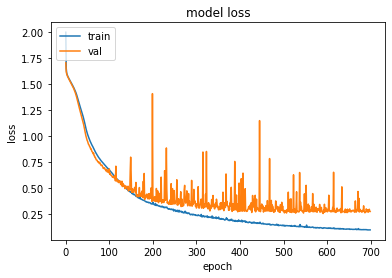

In [ ]:

plt.plot(rnn_hist.history['loss'])
plt.plot(rnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_predicted = model.predict(x_testrnn)

In [ ]:
import seaborn as sns
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

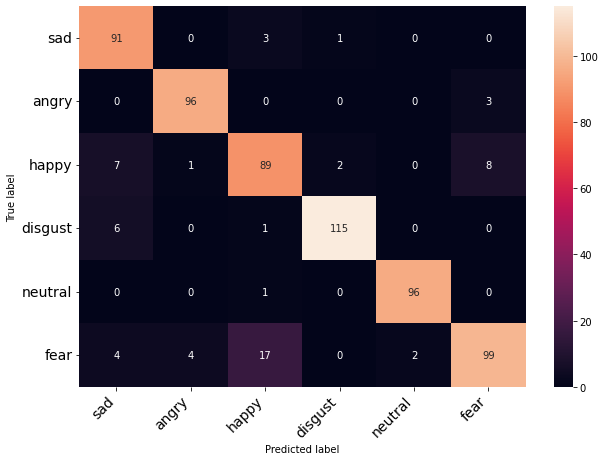

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test.argmax(axis=1), test_predicted.argmax(axis=1))
print_confusion_matrix(c, observed_emotions)

In [ ]:
score = model.evaluate(x_testrnn, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print(precision(test_predicted, y_test))
print(recall(test_predicted, y_test))
print(fscore(test_predicted, y_test))

accuracy: 90.71%
tf.Tensor(0.9009288, shape=(), dtype=float32)
tf.Tensor(0.9122257, shape=(), dtype=float32)
tf.Tensor(0.90654206, shape=(), dtype=float32)


RNN adam

In [ ]:
hidden_units = 35
input_shape=(X_train.shape[1],1)
dense_units = 6

model2 = Sequential()
model2.add(keras.layers.SimpleRNN(hidden_units, input_shape=input_shape,activation='relu'))
model2.add(Dense(units=dense_units, activation='softmax'))
opt2 = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy', fscore])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 35)                1295      
                                                                 
 dense_1 (Dense)             (None, 6)                 216       
                                                                 
Total params: 1,511
Trainable params: 1,511
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_reduce2 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

rnn_hist2 = model2.fit(x_trainrnn,y_train,batch_size=16, epochs=700, validation_data=(x_valrnn, y_val))

Epoch 1/700
142/142 [==============================] - 3s 13ms/step - loss: 2.7484 - accuracy: 0.1678 - fscore: 0.1014 - val_loss: 2.4382 - val_accuracy: 0.1579 - val_fscore: 0.0805
Epoch 2/700
142/142 [==============================] - 1s 10ms/step - loss: 2.3527 - accuracy: 0.1797 - fscore: 0.0722 - val_loss: 2.1415 - val_accuracy: 0.1981 - val_fscore: 0.0480
Epoch 3/700
142/142 [==============================] - 1s 10ms/step - loss: 2.0976 - accuracy: 0.2098 - fscore: 0.0291 - val_loss: 1.9355 - val_accuracy: 0.2229 - val_fscore: 0.0330
Epoch 4/700
142/142 [==============================] - 1s 9ms/step - loss: 1.9075 - accuracy: 0.2603 - fscore: 0.0345 - val_loss: 1.7848 - val_accuracy: 0.2817 - val_fscore: 0.0380
Epoch 5/700
142/142 [==============================] - 1s 10ms/step - loss: 1.7609 - accuracy: 0.3046 - fscore: 0.0577 - val_loss: 1.6765 - val_accuracy: 0.3189 - val_fscore: 0.0866
Epoch 6/700
142/142 [==============================] - 1s 10ms/step - loss: 1.6494 - accura

In [ ]:
test_predicted2 = model2.predict(x_testrnn)

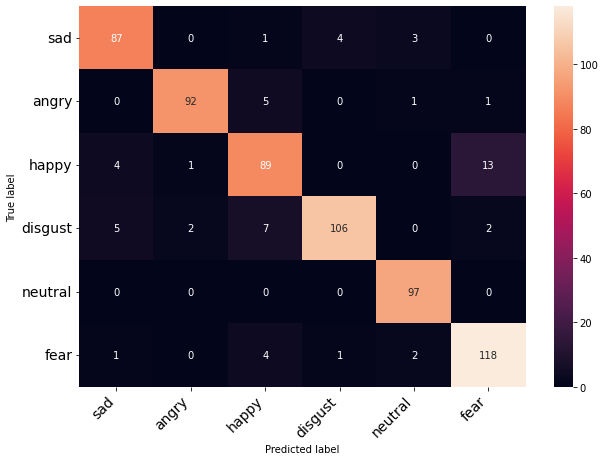

In [ ]:
c2 = confusion_matrix(y_test.argmax(axis=1), test_predicted2.argmax(axis=1))
print_confusion_matrix(c2, observed_emotions)

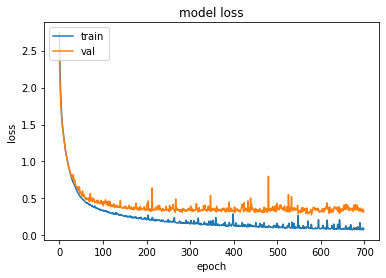

In [ ]:
plt.plot(rnn_hist2.history['loss'])
plt.plot(rnn_hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score2 = model2.evaluate(x_testrnn, y_test, verbose=0)
print("%s: %.2f%%" % (model2.metrics_names[1], score2[1]*100))
print(precision(test_predicted2, y_test))
print(recall(test_predicted2, y_test))
print(fscore(test_predicted2, y_test))

accuracy: 91.18%
tf.Tensor(0.9040248, shape=(), dtype=float32)
tf.Tensor(0.918239, shape=(), dtype=float32)
tf.Tensor(0.9110764, shape=(), dtype=float32)
